### Neste projeto, vamos dar uma de Dr. House e usar o TensorFlow Keras para treinar um modelo capaz de diagnosticar (classificar) imagens de célular com e sem Leucemia.

In [10]:
# Primeiramente, vamos definir o diretório onde estão as imagens
data_dir= Path(r'C:\Users\gilbe\Downloads\Imagens')

In [13]:
# Vamos solicitar ao instrumentador cirúrgico para preparar  as ferramentas que serão utilizadas no projeto
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from pathlib import Path

#####  Vamos verificar como essas imagens estão organizadas
##### As imagens estão em uma pasta do disco, separadas em subpastas, representando as duas classes de células.

In [17]:
# Vamos contar quantas imagens temos no total

img_count = len(list(data_dir.glob('*/*.jpg')))
print(img_count)

5460


In [46]:
# No total, são 5460 imagens, 50% de classe 'Leucemia' e 50% da classe 'Saudável'
list(data_dir.glob('*/'))

[WindowsPath('C:/Users/gilbe/Downloads/Imagens/Leucemia'),
 WindowsPath('C:/Users/gilbe/Downloads/Imagens/Saudavel')]

In [47]:
print(len(list(data_dir.glob('Leucemia/*'))))
print(len(list(data_dir.glob('Saudavel/*'))))

2730
2730


##### Vamos dar uma olhada em algumas dessas imagens

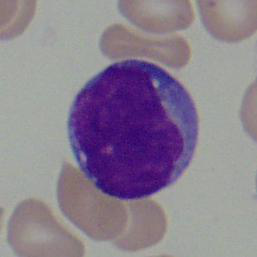

In [56]:
leucemia = list(data_dir.glob('Leucemia/*'))
PIL.Image.open(str(leucemia[0]))

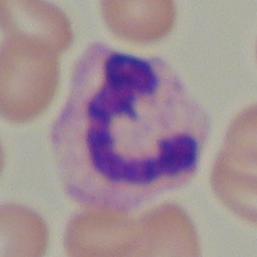

In [57]:
saudavel = list(data_dir.glob('Saudavel/*'))
PIL.Image.open(str(saudavel[0]))

##### Hora de carregar essas imagens para o Keras

In [58]:
# Vamos antes definir alguns parâmetros para o carregador:
batch_size = 32
img_height = 180
img_width = 180

##### Vamos dividir nossos dados em grupos de treino e de validação. Como dispomos de muitos exemplos, vou aplicar a proporção 80/20
##### 80% para treinar o modelo e 20% para avaliá-lo.

In [61]:
dados_treino = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=21,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5460 files belonging to 2 classes.
Using 4368 files for training.


In [62]:
dados_teste = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="validation",
    seed = 21,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 5460 files belonging to 2 classes.
Using 1092 files for validation.


#### Vamos usar o MatplotLib para vizualizar algumas imagens do conjunto de treinamento

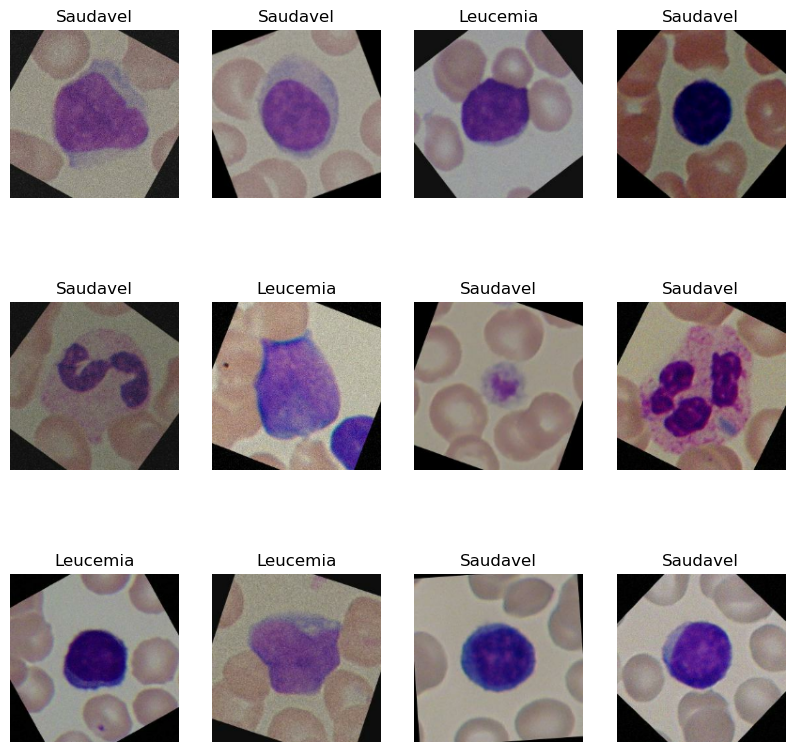

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
for img, lbl in dados_treino.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(dados_treino.class_names[lbl[i]])
        plt.axis("off")

#### O parâmetro batch_size que definimos acima serve para definir o tamanho dos lotes de imagens.

In [76]:
dados_treino

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#### Esses lotes tem formato 180 x 180 x 3.
#### Essa última dimensão representa os canais de cores RGB.
#### A escala RGB varia entre 0 (preto) até 255 (branco). Isso não é interessante para nós, já que vamos utilizar uma rede neural.
#### Precisamos alimentar nossa Neural Network com valores de entrada pequenos

#### Para fazer isso, vamos normalizar essa dimensão dos nossos dados com o Keras.

In [78]:
camada_normalizada = tf.keras.layers.Rescaling(1./255)

#### Veja que após a normalização, os dados estão agora dentro do intervalo entre 0 e 1

In [82]:
data_normalized = dados_treino.map(lambda x, y: (camada_normalizada(x),y))
img_batch, labels_batch = next(iter(data_normalized))
first_image = img_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.7780444


#### Certo, agora, estamos com quase tudo pronto para iniciar o treinamento do nosso modelo.
#### No entanto, precisamos estar atentos a um detalhe importante:

#### Esse tipo de tarefa (Visão Computacional) consome muitos recursos de processamento.
#### Precisamos garantir que a leitura dos dados que estão no disco não inviabilizem a execução ao tornar-se um gargalo.

#### Veja o que a documentação do Keras tem a nos dizer a esse respeito:

Dataset.cache mantém as imagens na memória depois de serem carregadas fora do disco durante a primeira época. Isso garantirá que o conjunto de dados não se torne um gargalo ao treinar seu modelo. Se seu conjunto de dados for muito grande para caber na memória, você também poderá usar esse método para criar um cache em disco de alto desempenho.

Dataset.prefetch sobrepõe o pré-processamento de dados e a execução do modelo durante o treinamento.

In [83]:
AUTOTUNE = tf.data.AUTOTUNE

dados_treino = dados_treino.cache().prefetch(buffer_size=AUTOTUNE)
dados_teste = dados_teste.cache().prefetch(buffer_size=AUTOTUNE)

## Treinando o modelo

#### Vamos utilizar o modelo Sequencial do Keras: uma rede neural composta de três blocos de convolução,  uma camada de de agrupamento máximo em cada um deles e uma camada densa.

#### A função de ativação ReLu é um elemento essencial para nossa rede neural. 

####Essa função consiste em preservar valores positivos e transformar valores negativos em zeros. A conversão é rápida mas se a ocorrência de saídas negativas for alta muitos neurônios não serão ativados: 
𝑔(𝑧)={0,𝑧<0𝑧,𝑧≥0 

#### Também usaremos o otimizador Adam e a função de perda SparseCategoricalCrossEntropy

In [84]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [85]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

## Vamos treinar o modelo!

In [88]:
model.fit(
  dados_treino,
  validation_data=dados_teste,
  epochs=4
)

Epoch 1/4
137/137 ━━━━━━━━━━━━━━━━━━━━ 54s 396ms/step - accuracy: 0.9340 - loss: 0.1520 - val_accuracy: 0.9396 - val_loss: 0.1621
Epoch 2/4
137/137 ━━━━━━━━━━━━━━━━━━━━ 56s 406ms/step - accuracy: 0.9523 - loss: 0.1213 - val_accuracy: 0.9386 - val_loss: 0.1695
Epoch 3/4
137/137 ━━━━━━━━━━━━━━━━━━━━ 55s 403ms/step - accuracy: 0.9616 - loss: 0.1016 - val_accuracy: 0.9441 - val_loss: 0.1153
Epoch 4/4
137/137 ━━━━━━━━━━━━━━━━━━━━ 61s 443ms/step - accuracy: 0.9663 - loss: 0.0831 - val_accuracy: 0.9679 - val_loss: 0.0913


#### Com 4 épocas de treinamento, alcançamos 96% de acurácia na etapa de treinamento.

In [92]:
model.evaluate(dados_teste, verbose = "auto")

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9660 - loss: 0.0966


[0.0912761315703392, 0.9679487347602844]

## Conclusão

#### Usando um notebook HP com processador i5 e 8GB de RAM, consegui implementar uma rede neural para classificação de células saudáveis ou com Leucemia.

#### É claro que em se tratando de medicina, testes mais rigorosos devem ser aplicados, mas não entrarei nesse mérito.

#### Meu objetivo foi demonstrar como a Inteligência Artificial pode ser aplicada no contexto da medicina e trazer bons resultados para todos nós.